In [30]:
from __future__ import print_function
from ga4gh.client import client
import pandas as pda
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv

# Silence https warnings
# https://stackoverflow.com/questions/27981545/suppress-insecurerequestwarning-unverified-https-request-is-being-made-in-pytho
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


def population_dictionaries(filename):
    popdict = {}
    subpopdict = {}
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            sample = row['sample']
            popdict[sample] = row['population']
            subpopdict[sample] = row['subpopulation']

    return popdict, subpopdict

    
def population_to_colors(populations):
    pop_to_rgb = { 'ACB': (0.84, 0.52, 0.13, 1.0), 'GWD': (0.96, 0.92, 0.18, 1.0),
                   'BEB': (0.37, 0.07, 0.43, 1.0), 'PEL': (0.71, 0.02, 0.1, 1.0),
                   'LWK': (0.72, 0.6, 0.3, 1.0), 'MSL': (0.8, 0.67, 0.15, 1.0),
                   'GBR': (0.48, 0.72, 0.79, 1.0), 'IBS': (0.35, 0.43, 0.66, 1.0),
                   'ASW': (0.77, 0.32, 0.11, 1.0), 'TSI': (0.12, 0.13, 0.32, 1.0),
                   'KHV': (0.39, 0.64, 0.22, 1.0), 'CEU': (0.17, 0.23, 0.53, 1.0),
                   'SAS': (0.52, 0.27, 0.54, 1.0), 'EAS': (0.67, 0.76, 0.15, 1.0),
                   'AMR': (0.45, 0.13, 0.11, 1.0), 'YRI': (0.92, 0.75, 0.36, 1.0),
                   'CHB': (0.67, 0.77, 0.16, 1.0), 'CLM': (0.62, 0.14, 0.16, 1.0),
                   'CHS': (0.45, 0.67, 0.19, 1.0), 'ESN': (0.94, 0.77, 0.14, 1.0),
                   'FIN': (0.39, 0.68, 0.74, 1.0), 'AFR': (0.97, 0.92, 0.24, 1.0),
                   'GIH': (0.32, 0.19, 0.5, 1.0), 'PJL': (0.69, 0.0, 0.45, 1.0),
                   'EUR': (0.53, 0.73, 0.84, 1.0), 'STU': (0.5, 0.25, 0.54, 1.0),
                   'MXL': (0.69, 0.0, 0.16, 1.0), 'ITU': (0.53, 0.13, 0.31, 1.0),
                   'CDX': (0.32, 0.56, 0.2, 1.0), 'JPT': (0.25, 0.49, 0.2, 1.0),
                   'PUR': (0.62, 0.14, 0.16, 1.0)}

    if type(populations) is list:
        colors = [ pop_to_rgb[pop] for pop in populations ] 
    else:
        colors = pop_to_rgb[populations]

    return colors

    
def get_ga4gh_genotypes_dataframe(url, chrom, start, end):
    """
    Returns a DataFrame of genotypes within the requested coordinates for all
    callsets.
    
    e.g.
                            index  HG00099  HG001031
    0    10_94951137_94951138_C_A      0.0      0.0    
    1    10_94951708_94951709_C_T      0.0      0.0    
    2    11_89179334_89179335_T_C      0.0      0.0    
    3    11_89183935_89183936_G_A      0.0      0.0    
    4    11_89207230_89207231_T_A      0.0      0.0    
    5    11_89207617_89207618_T_A      0.0      0.0    
    6    11_89207714_89207715_C_A      0.0      0.0    
    7    11_89216311_89216312_A_C      0.0      0.0    
    8    11_89219122_89219123_T_A      0.0      0.0
    (...)
    [XX rows x YY columns]

    XX variants x YY callsets.

    index = <chrom>_<start>_<end>_<ref>_<alt>

    :param str url: The url of the ga4gh server.
    :param str chrom: The chromosome for the region of interest.
    :param int start: The start position for the region of interest.
    :param str end: The end position for the region of interest.

    :return A DataFrame of genotypes within the requested coordinates for all
    callsets.
    rtype: DataFrame
    """

    chrom = chrom.replace('chr','')
    region = chrom+":"+str(start)+"-"+str(end)
    print ("chrom:{}, start:{}, end:{}".format(chrom, start, end))
    
    httpClient = client.HttpClient(url)
    
    # Get the datasets on the server.
    datasets = list(httpClient.search_datasets())
    

    # TODO: Assumption - uses the first dataset.
    # Get the variantSets in the first dataset.
    variantSets = list(httpClient.search_variant_sets(
        dataset_id=datasets[0].id))

    # TODO: Assumption - uses the first variantset.
    # Get the variants in the interval [<start>, <end>) on chromosome <chrom>
    # in the first variantSet.
    callSets = list(httpClient.search_call_sets(variantSets[0].id))

    iterator = httpClient.search_genotypes(
        variant_set_id=variantSets[0].id,
        reference_name=chrom, start=start, end=end,
        call_set_ids=[callset.id for callset in callSets])


    var_ids = ["%s_%s_%s_%s_%s" % (variant.reference_name,
                                   variant.start,
                                   variant.end,
                                   variant.reference_bases,
                                   "".join(variant.alternate_bases))
               for variant in iterator[1]]
    var_ids = np.matrix(var_ids)

    individuals = iterator[2]
    nvariants = iterator[0].nvariants
    nindividuals = iterator[0].nindividuals

    genotype_matrix = np.matrix(iterator[0].genotypes).reshape(nvariants, nindividuals).T

    # Add var_ids index
    genotype_matrix = np.concatenate((var_ids, genotype_matrix)).T

    # return DataFrame
    genotype_dataframe = pda.DataFrame(genotype_matrix, columns = ['index'] + list(individuals))

    return genotype_dataframe


def get_ga4gh_genotypes(servers, regions):
    """
    Returns a DataFrame of genotypes within the requested coordinates for all
    callsets. The data is merged from multiple ga4gh servers and multiple
    regions.

    :param list servers: A list of ga4gh servers <str> to query.
    :param list regions: A list of regions to query.
    e.g. [region1, region2, ...]
         region1 = {'chrom':<chrom>, 'start':<start>, 'end':<end>}
         ...

    return: a DataFrame of genotypes within the requested coordinates for all
    callsets.
    rtype: DataFrame
    """

    # When init == True,
    init = True

    num_servers = len(servers) - 1

    # for each server, query all regions then merge
    for j, server in enumerate(servers):

        G = pda.DataFrame()

        num_regions = len(regions) - 1

        # query a DataFrame of genotypes for all regions
        # G is the merged DataFrame for all regions

        # e.g.
        # region1
        #                            index  HG00099  HG001031
        #    0    10_94951137_94951138_C_A      0.0      0.0    
        # region2
        #                            index  HG00099  HG001031
        #    0    10_94951708_94951709_C_T      0.0      0.0    
        # G = region1 + region2
        #                            index  HG00099  HG001031
        #    0    10_94951137_94951138_C_A      0.0      0.0    
        #    1    10_94951708_94951709_C_T      0.0      0.0    
        for i, reg in enumerate(regions):
            # merge regions
            df = get_ga4gh_genotypes_dataframe(server, reg['chr'], reg['start'], reg['end'])
            G = G.append(df)
            print(j, '/', num_servers, '|',  i, '/', num_regions, '|', 'G:', G.shape, '\n')

        # G is a merged DataFrame for all regions for one server
        # Merge each G into AllG (i.e. a merge across callsets for each server).
        # Merge on the index = <chrom>_<start>_<end>_<ref>_<alt>
        # If the same callset exists on multiple servers, all will be kept.
            
        # e.g.
        # server1
        #                            index  HG00099
        #    0    10_94951137_94951138_C_A      0.0
        #    1    10_94951708_94951709_C_T      0.0
        # server2
        #                            index  HG001031
        #    0    10_94951137_94951138_C_A      0.0    
        #    1    10_94951708_94951709_C_T      0.0    
        # AllG = server1 + server2
        #                            index  HG00099  HG001031
        #    0    10_94951137_94951138_C_A      0.0      0.0    
        #    1    10_94951708_94951709_C_T      0.0      0.0    
        if init:
            AllG = G
            init = False
        else:
            AllG = AllG.merge(G, how='outer', left_on='index', right_on='index')
        print('AllG:', AllG.shape, '\n')

    # replace all NaN with 0 -> assume 0/0
    AllG = AllG.fillna(0)

    return AllG

def get_ga4gh_subpops(server):
    import ga4gh.client.client

    baseURL = server
    client = ga4gh.client.client.HttpClient(baseURL)

    datasets = list(client.search_datasets())
    datasetId=datasets[0].id
    individuals = client.search_individuals(datasetId)
    ancestry_dict = { i.name: i.description for i in individuals }

    return ancestry_dict



In [4]:
servers = [
    "https://ga4gh.ccm.sickkids.ca/ga4gh/",
    "http://ga4gh.pmgenomics.ca/ga4gh/",
]
regions = [
    {'chr':'chr20', 'start':0, 'end':500000},
]

df = get_ga4gh_genotypes(servers, regions)
df = df.apply(pda.to_numeric, errors='ignore')

AllG: (12065, 1671) 

1 / 1 | 0 / 0 | G: (9245, 836) 

0 / 1 | 0 / 0 | G: (9340, 836) 

AllG: (9340, 836) 

chrom:20, start:0, end:500000
chrom:20, start:0, end:500000


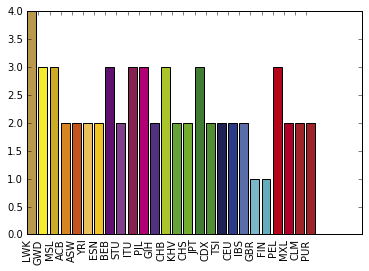

In [31]:
variants_sum = df.sum(axis=1)
singletons = df[variants_sum == 1]
singletons = singletons.apply(pda.to_numeric, errors='ignore')
num_singletons = singletons.sum(axis=0)
Sgl = zip(num_singletons.index, num_singletons)[1:]

#reading pops and subpops
pops, subpops = population_dictionaries('samples-pops-subpops.csv')

subpops = {}
for server in servers:
    subpops.update(get_ga4gh_subpops(server))
   
ordered_subpops = ['LWK', 'GWD', 'MSL', 'ACB','ASW','YRI', 'ESN','BEB', 'STU','ITU', 'PJL','GIH','CHB','KHV','CHS','JPT','CDX','TSI','CEU','IBS','GBR','FIN','PEL','MXL','CLM','PUR']    
subpop_sum = {}
subpop_count = {}


subpop_sum = subpop_sum.fromkeys(ordered_subpops, 0)
subpop_count = subpop_count.fromkeys(ordered_subpops, 0)


for key, val in enumerate(Sgl):
    subpop_sum[subpops[val[0]]] += val[1]
    subpop_count[subpops[val[0]]] += 1 
  
averages = []
for i, key in enumerate(ordered_subpops):
    if not subpop_count[key] == 0:
        averages.append(subpop_sum[key]/subpop_count[key])
    else:
        averages.append(0)


colors = population_to_colors(ordered_subpops)
mpl.rc('xtick', labelsize=10)
mpl.rcParams['axes.formatter.useoffset'] = False
plt.bar(range(0, len(averages), 1), averages, color=colors, tick_label=ordered_subpops, edgecolor='k')
plt.xticks(rotation=90)
plt.show()